# MATLAB vs Python Versions of ATaCR

--- ALL DIFFERENCES FOUND::

    1. --------------Filtering disagreement during event correction--------------
    	1. A lowpass filter & taper is performed on the transfer functions in b4_CorrectEvent that is not present anywhere in the Python version.


    2. --------------Averaging choice for deriving TFs--------------
    	1. By default, both codes use the transfer functions made from the DAY AVERAGE preceding the event time.
    		1. That said, the pre-event time window that determines this TF selection is very slightly different in the two codes. The ML version requires both start and end times of the TF to preceed the event. The python version only requires the start time to be before the event (ie the event occurs WITHIN the TF window).


    3. --------------Choosing the pre-event TF--------------
    	1. Unlike the Matlab version, there is nothing in the Python code to stop individual trace data (SAC files) to be less than an entire day of recording. Thus an edge case exist when querying times from IRIS to yield hour long traces (ie many deployments retain SAC files in hour resolution).


    4. --------------Tilt Searching for H--------------
    	1. Both codes use the same tilt frequency range ([.005, .035]) when determining maximum coherence.


    5. --------------Filter differences--------------
    	1. In the Python version, station spectra at every level of processing (ie quality control at lines 232 and 276 of atacr_clean_spectra and atacr_clean_spectra, respectively) has a SIGNIFICANTLY higher corner ([0.004 2.0] Hz) than the Matlab version ([0.004 0.2] Hz).


    6. --------------Hanning Taper Inconsistency--------------
    	1. The hanning taper appears to be twice as long in the Matlab version compared to Python's version. Admittedly, its possible ML's hanning might operate differently than Numpy's, hanning(2x_num_pts_to_overlap), but I would doubt it based on the documentation for them.


    7. --------------Inconsistencies in power spectra station averages--------------
    	1. While they are station averages and not used for deriving the TFs (by default), their is marked inconsistencies in power and fq when comparing the two code outputs. As stated above, the bandpass for Python is significantly wider and although this alone wouldn't shift spectra, it's possible when this is combined with the hanning taper Python uses (and ML does not) it might create this marked disagreement in spectral averages for stations.
    		1. There is a much deeper dive needed to confirm and quantify the significant disagreements shown in how spectra are pre-processed and averaged differently between the two codes.
    		2. That said, the final product of corrected event traces seem largely in agreement with each other to an extent I question whether I understand this spectra disagreement issue correctly or overestimate its effect on the ATaCR method.


    8. --------------In final product comparisons--------------
    	1. The corrected event traces seem nearly identical in nearly all cases looked at so far.

---


In [15]:
# %cd /Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp
import glob as g
import pickle as pkl
import pandas as pd
import numpy as np
import scipy as sc
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import clear_output, display #Only works in notebooks

import noisecut
import obstools
from obstools.atacr import DayNoise, TFNoise, EventStream, StaNoise, utils
import obstools.atacr.plotting as atplot
from obspy.core import read, Stream, Trace, AttribDict, UTCDateTime
from obspy.clients.fdsn import Client
from obstools.atacr.plotting import fig_QC, fig_average, fig_av_cross, fig_coh_ph, fig_TF, fig_comply, fig_event_raw, fig_event_corrected
from numpy.lib.stride_tricks import sliding_window_view
import seaborn as sns
import datetime
# My Frankenstein of QA tools:
import ObsQA

# Map stuff
import folium
from branca.element import Figure


import math
import numpy as np
import librosa
from obspy import Trace
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib
import sys
import obspy
import pickle as pkl
import glob as g
from obspy.clients.fdsn import Client
import datetime
import re
import math
from numpy import linalg as eigen
# import noisecut
# ------------------------------------
sys.path.insert(1,'/Users/charlesh/Documents/Codes/ATaCR')
sys.path.insert(1,'/Users/charlesh/Documents/Codes/')
import ObsQA
import ObsQA as ob
from ObsQA.plots import qtp
from ObsQA import *
import obstools as obs
import cmath
import subset
stas = subset.stas
sys.path.insert(1,'/Users/charlesh/Documents/Codes/')
import matplotlib.colors as mcolors
from scipy.stats import norm
# import ntk

### The selection of stations in this QA subarray is based primarily on having a wide variety in station depth and underlying sediment thickness, however I also required all 4 channels to be working, only use APG pressure gauge stations (when possible), and as much variety amongst all the other metrics (network, environment, seismometer,etc.) as would allow while keeping the list short. The final list is 18 stations from three different experiments.

In [16]:
# Important Directories
CompFolder = '/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp'
ATaCR_ML_DataFolder,ATaCR_Py_DataFolder = ObsQA.io.dir_libraries(CompFolder)
stations, stations_set = ObsQA.io.getstalist()

In [17]:
stations, stations_set = ObsQA.io.getstalist()
stations_set = stations_set.sort_values(by=['Network','Station'])
stations_set

,Station,Network,Latitude (deg),Longitude (deg),Experiment,Instrument Design,Seismometer,Environment,Pressure Gauge,Water Depth (m),...,Deployment Length (days),Good Channels,n_events,Magnitude_mw,Origin,Metadata,Averaging,Events,Files,Depth_KM
0,FN07A,7D,46.855499,-124.786499,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,154.000000,...,359,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FN07C,7D,46.855400,-124.786003,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,158.000000,...,302,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FN12C,7D,46.888699,-125.119003,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,656.000000,...,301,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FN14A,7D,47.024799,-124.964699,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,173.000000,...,356,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FS15B,7D,40.492599,-124.512604,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,52.000000,...,294,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,G03A,7D,40.059101,-126.162498,CASCADIA INITIATIVE,KE,Guralp CMG3T 120,North Pacific,DPG,4113.000000,...,179,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,G03D,7D,40.058701,-126.161201,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,4056.500000,...,412,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,G04D,7D,40.157700,-126.784698,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,4350.300000,...,412,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,G34D,7D,42.572300,-125.448601,CASCADIA INITIATIVE,BA,Trillium Compact,North Pacific,APG,3089.000000,...,390,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,J11B,7D,43.541401,-126.367302,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,3030.000000,...,346,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# stations_set.sort_values(by=['Network','Station'])
# stations_set.sort_values(by=['Network'])


ATaCR_Py_DataFolder = obs.utilities.io.Get_ATaCR_Dirs('/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp')
eventsfolder = ATaCR_Py_DataFolder['Py_CorrectedTraces']
catalog = pd.read_pickle(eventsfolder + '/event_catalog.pkl')
display(catalog)

stations = catalog

,Station,Network,Latitude (deg),Longitude (deg),Experiment,Instrument Design,Seismometer,Environment,Pressure Gauge,Water Depth (m),...,Deployment Length (days),Good Channels,n_events,Magnitude_mw,Origin,Metadata,Averaging,Events,Files,Depth_KM
0,FN07A,7D,46.855499,-124.786499,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,154.000000,...,359,True,7,"[6.7, 6.3, 6.3, 6.4, 6.3, 6.4, 6.3]","[2012-04-21T01:16:53.670000Z, 2012-06-04T00:45...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta, sta, sta, sta]","[2012.112.01.16, 2012.156.00.45, 2012.185.10.3...","[2012.112.01.16.HHZ.SAC, 2012.156.00.45.HHZ.SA...","[24.4, 15.0, 239.0, 164.8, 8.2, 12.8, 17.1]"
1,FN07C,7D,46.855400,-124.786003,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,158.000000,...,302,True,3,"[6.4, 6.6, 6.4]","[2014-06-24T03:15:38.920000Z, 2014-06-29T17:15...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta]","[2014.175.03.15, 2014.180.17.15, 2014.180.15.52]","[2014.175.03.15.HHZ.SAC, 2014.180.17.15.HHZ.SA...","[23.2, 26.0, 26.0]"
2,FN12C,7D,46.888699,-125.119003,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,656.000000,...,301,True,5,"[6.4, 6.6, 6.4, 6.3, 6.7]","[2014-06-24T03:15:38.920000Z, 2014-06-29T17:15...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta, sta]","[2014.175.03.15, 2014.180.17.15, 2014.180.15.5...","[2014.175.03.15.HHZ.SAC, 2014.180.17.15.HHZ.SA...","[23.2, 26.0, 26.0, 16.7, 19.6]"
3,FN14A,7D,47.024799,-124.964699,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,173.000000,...,356,True,4,"[6.7, 6.3, 6.4, 6.3]","[2012-05-28T05:07:23.520000Z, 2012-07-03T10:36...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta]","[2012.149.05.07, 2012.185.10.36, 2012.188.02.2...","[2012.149.05.07.HHZ.SAC, 2012.185.10.36.HHZ.SA...","[591.1, 239.0, 164.8, 17.1]"
4,FS15B,7D,40.492599,-124.512604,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,52.000000,...,294,True,4,"[6.3, 6.5, 6.4, 6.7]","[2013-06-15T16:11:02.090000Z, 2013-06-24T22:04...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta]","[2013.166.16.11, 2013.175.22.04, 2013.166.17.3...","[2013.166.16.11.HHZ.SAC, 2013.175.22.04.HHZ.SA...","[21.5, 17.5, 41.4, 632.0]"
5,G03A,7D,40.059101,-126.162498,CASCADIA INITIATIVE,KE,Guralp CMG3T 120,North Pacific,DPG,4113.000000,...,179,True,4,"[6.7, 6.3, 6.7, 6.7]","[2012-04-17T03:50:15.280000Z, 2012-04-14T22:05...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta]","[2012.108.03.50, 2012.105.22.05, 2012.112.01.1...","[2012.108.03.50.BHZ.SAC, 2012.105.22.05.BHZ.SA...","[29.7, 11.4, 24.4, 132.5]"
6,G03D,7D,40.058701,-126.161201,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,4056.500000,...,412,True,4,"[6.6, 6.6, 6.6, 6.5]","[2014-11-07T03:33:55.020000Z, 2014-10-09T02:32...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta]","[2014.311.03.33, 2014.282.02.32, 2015.222.04.1...","[2014.311.03.33.BHZ.SAC, 2014.282.02.32.BHZ.SA...","[53.4, 10.5, 20.0, 11.3]"
7,G04D,7D,40.157700,-126.784698,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,4350.300000,...,412,True,9,"[6.7, 6.7, 6.7, 6.6, 6.6, 6.6, 6.6, 6.5, 6.7]","[2015-05-01T08:06:05.600000Z, 2015-07-10T04:12...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta, sta, sta, sta, sta, sta]","[2015.121.08.06, 2015.191.04.12, 2015.115.06.4...","[2015.121.08.06.BHZ.SAC, 2015.191.04.12.BHZ.SA...","[63.6, 20.0, 14.7, 53.4, 17.8, 10.5, 20.0, 11...."
8,G34D,7D,42.572300,-125.448601,CASCADIA INITIATIVE,BA,Trillium Compact,North Pacific,APG,3089.000000,...,390,True,5,"[6.3, 6.5, 6.4, 6.5, 6.7]","[2015-07-07T05:10:27.860000Z, 2015-08-12T18:49...","[[[resource_id, event_type, event_type_certain...","[sta, sta, sta, sta, sta]","[2015.188.05.10, 2015.224.18.49, 2015.184.01.0...","[2015.188.05.10.HHZ.SAC, 2015.224.18.49.HHZ.SA...","[51.1, 11.3, 19.0, 19.4, 20.0]"
9,J11B,7D,43.541401,-126.

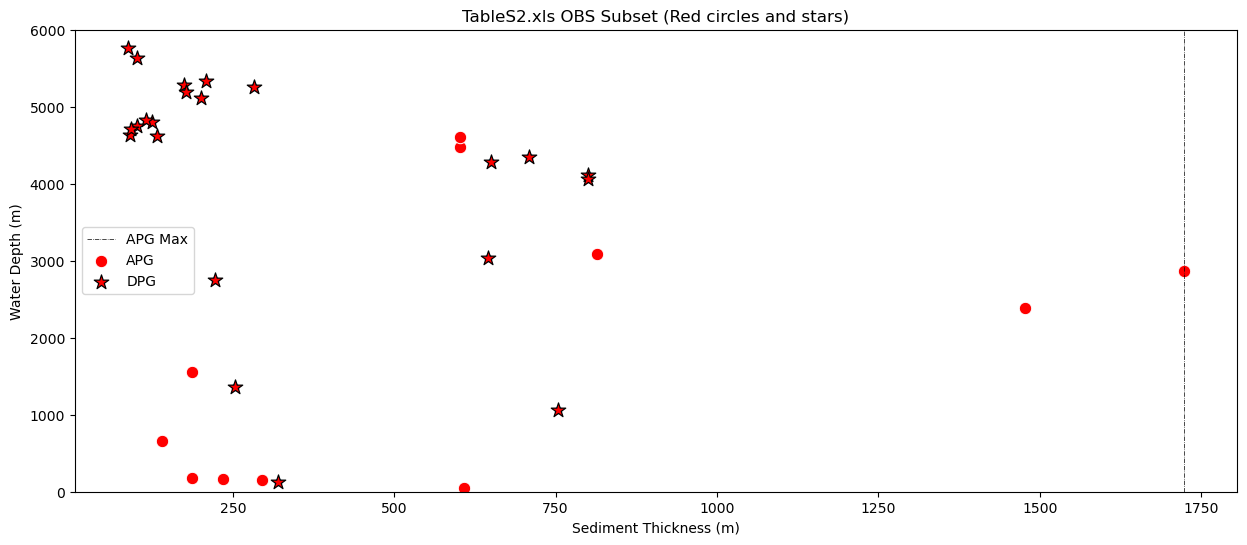

,Station,Network,Latitude (deg),Longitude (deg),Experiment,Instrument Design,Seismometer,Environment,Pressure Gauge,Water Depth (m),...,Deployment Length (days),Good Channels,n_events,Magnitude_mw,Origin,Metadata,Averaging,Events,Files,Depth_KM
0,FN07A,7D,46.855499,-124.786499,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,154.000000,...,359,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FN07C,7D,46.855400,-124.786003,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,158.000000,...,302,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FN12C,7D,46.888699,-125.119003,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,656.000000,...,301,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FN14A,7D,47.024799,-124.964699,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,173.000000,...,356,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FS15B,7D,40.492599,-124.512604,CASCADIA INITIATIVE,TRM,Trillium Compact,North Pacific,APG,52.000000,...,294,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,G03A,7D,40.059101,-126.162498,CASCADIA INITIATIVE,KE,Guralp CMG3T 120,North Pacific,DPG,4113.000000,...,179,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,G03D,7D,40.058701,-126.161201,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,4056.500000,...,412,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,G04D,7D,40.157700,-126.784698,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,4350.300000,...,412,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,G34D,7D,42.572300,-125.448601,CASCADIA INITIATIVE,BA,Trillium Compact,North Pacific,APG,3089.000000,...,390,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,J11B,7D,43.541401,-126.367302,CASCADIA INITIATIVE,AR,Trillium Compact,North Pacific,DPG,3030.000000,...,346,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
maxsed_apg = stations.iloc[np.where(np.array(np.array(stations['Sediment Thickness (m)']>1700) & np.array(stations['Pressure Gauge']=='APG')))]['Sediment Thickness (m)'].max()
plt.figure(figsize=(15,6))
plt.plot((maxsed_apg,maxsed_apg),(0,6000),linewidth=.5,linestyle='-.',c='k',label='APG Max')
sns.scatterplot(x=stations['Sediment Thickness (m)'], y=stations['Water Depth (m)'])
sns.scatterplot(x=stations_set.iloc[np.where(stations_set['Pressure Gauge']=='APG')]['Sediment Thickness (m)'], y=stations_set.iloc[np.where(stations_set['Pressure Gauge']=='APG')]['Water Depth (m)'],color='r',label='APG',s=80)
sns.scatterplot(x=stations_set.iloc[np.where(stations_set['Pressure Gauge']=='DPG')]['Sediment Thickness (m)'], y=stations_set.iloc[np.where(stations_set['Pressure Gauge']=='DPG')]['Water Depth (m)'],color='r',s=120,marker='*',label='DPG',facecolor='r',edgecolor='k')
plt.gca().set_ylim((0,6000))
plt.title('TableS2.xls OBS Subset (Red circles and stars)')
plt.show()


display(stations_set)


tilekey = dict()
# good map tiles: http://leaflet-extras.github.io/leaflet-providers/preview/
tilekey[0] = ('https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}','Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri')
tilekey[1] = ('https://server.arcgisonline.com/ArcGIS/rest/services/World_Terrain_Base/MapServer/tile/{z}/{y}/{x}','Tiles &copy; Esri &mdash; Source: USGS, Esri, TANA, DeLorme, and NPS')
tilekey[2] = ('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}','Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')
key = 0
fig = Figure(width=1150, height=500)
locationlist = (np.array((stations['Latitude (deg)'],list(stations['Longitude (deg)']))).T.tolist())
locationlist_subset = (np.array((stations_set['Latitude (deg)'],list(stations_set['Longitude (deg)']))).T.tolist())
m = folium.Map(tiles=tilekey[key][0],attr=tilekey[key][1],fit_bounds=[stations[['Latitude (deg)', 'Longitude (deg)']].min().values.tolist(), stations[['Latitude (deg)', 'Longitude (deg)']].max().values.tolist()],min_zoom=1.5,zoom_click=True).add_child(folium.LatLngPopup())
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=list(stations['Network'] + '.' + list(stations['Station']))[point],icon=folium.Icon(color='white',icon_color='blue',prefix='fa',icon='caret-up',shadow_size=0,icon_size=(0,0),icon_anchor=(0,0))).add_to(m)
for point in range(0, len(locationlist_subset)):
    folium.Marker(locationlist_subset[point], popup=list(stations_set['Network'] + '.' + list(stations_set['Station']))[point],icon=folium.Icon(color='white',icon_color='red',prefix='fa',icon='caret-up',shadow_size=0,icon_size=(0,0),icon_anchor=(0,0))).add_to(m)
m.fit_bounds([stations_set[['Latitude (deg)','Longitude (deg)']].min().tolist(), stations_set[['Latitude (deg)','Longitude (deg)']].max().tolist()])
fig.add_child(m)

## NOTE: This 18-n subarray hasn't been downloaded yet. The below is still just four stations: M01A, M02A, M07A, M08A

In [20]:
sps = 5
network = '7D'
stalist = ['M07A','M08A']
event_time = '201203090709'
eventtime_jdaystr = str(UTCDateTime(event_time).year) + '.' + str(UTCDateTime(event_time).julday).zfill(3) + '.' + str(UTCDateTime(event_time).hour).zfill(2) + '.' + str(UTCDateTime(event_time).minute).zfill(2)

In [21]:
ATaCR_Py_DataFolder['Py_CorrectedTraces']

'/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/EVENTS'

In [22]:
stalist

['M07A', 'M08A']

In [ ]:
print('---------------------------------------------------------------------------------------------------------')
print('--------------------------------------C O R R E C T E D   T R A C E S-------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
ml_preprocfolder = ATaCR_ML_DataFolder['ML_PreProcEventData']
ml_correctedfolder = ATaCR_ML_DataFolder['ML_CorrectedTraces']
tffolder = ATaCR_ML_DataFolder['ML_TransferFunctions']

py_correctedfolder = ATaCR_Py_DataFolder['Py_CorrectedTraces']
py_preprocfolder = ATaCR_Py_DataFolder['Py_CorrectedTraces']

ml_folders = [ATaCR_ML_DataFolder['ML_PreProcEventData'],ATaCR_ML_DataFolder['ML_CorrectedTraces'],ATaCR_ML_DataFolder['ML_TransferFunctions']]
py_folders = [ATaCR_Py_DataFolder['Py_CorrectedTraces'],ATaCR_Py_DataFolder['Py_CorrectedTraces'],ATaCR_Py_DataFolder['Py_TransferFunctions']]

ObsQA.plots.Comp_PyML_EventData(event_time,network,stalist,py_folders,ml_folders)

obstools.atacr.plotting.fig_event_corrected(evstream, TF_list, fmin=0.006666666666666667, fmax=2.0)

Function to plot the corrected vertical component seismograms.

Parameters
:
evstream (EventStream) – Container for the event stream data

Tf_list (list) – List of Dictionary elements of transfer functions used for plotting the corrected vertical component.


In [ ]:
k = 'ML_StaSpecAvg'
# k = 'ML_b1b2_StaSpectra'

print('---------------------------------------------------------------------------------------------------------')
print('--------------------------------------STATION AVERAGED SPECTRA-------------------------------------')
print('---------------------------------------------------------------------------------------------------------')

for stai in stalist:
    folder = ATaCR_ML_DataFolder[k]
    if k=='ML_b1b2_StaSpectra':
        folder = ATaCR_ML_DataFolder[k] + '/' + network + '/' + stai + '/b1'
        folder = ATaCR_ML_DataFolder[k] + '/' + network + '/' + stai + '/b2'
    ml_files = g.glob(folder + '/*.mat')
    d = ObsQA.io.mat2df(ml_files)
    if k=='ML_StaSpecAvg':
        d = d[((d['network']==network)) & (d['station']==stai)].iloc[0]
        power = obstools.atacr.classes.Power(c11=np.atleast_2d(np.array(np.array(d.c11_mean.tolist()))).T,c22=np.atleast_2d(np.array(np.array(d.c22_mean.tolist()))).T,cZZ=np.atleast_2d(np.array(np.array(d.czz_mean.tolist()))).T,cPP=np.atleast_2d(np.array(np.array(d.cpp_mean.tolist()))).T)
    else:
        d = d[((d['network']==network)) & (d['station']==stai)]
        power = obstools.atacr.classes.Power(c11=np.atleast_2d(np.array(np.array(d.c11_stack.tolist()))).T,c22=np.atleast_2d(np.array(np.array(d.c22_stack.tolist()))).T,cZZ=np.atleast_2d(np.array(np.array(d.czz_stack.tolist()))).T,cPP=np.atleast_2d(np.array(np.array(d.cpp_stack.tolist()))).T)
    ncomp = 4
    # Spectral Average of ML-ATaCR Data
    f = np.array(list(d.f))
    print('File Chosen: ' + d.File)
    if k=='ML_StaSpecAvg':
        print('Days Used: ' )
        print([list(tmp.values())[0] for tmp in d.daysused])
    key = 'Matlab_ATaCR - Station-AVERAGE ' + (d.File)
    gooddays = np.array([True],dtype=bool)
    fig_QC(f, power, gooddays, ncomp, key)
    plt.show()
    # ------
    folder = ATaCR_Py_DataFolder['Py_StaSpecAvg']
    path = folder + '/' + network + '.' + stai + '/'
    py_files = g.glob(path + '*.pkl')
    # print('Python-ATaCR Files: ' + str(len(py_files)))
    display(py_files)
    f = py_files[0]
    file = open(f, 'rb')
    pydata = pkl.load(file)
    fq = pydata.f
    gooddays = np.array([True],dtype=bool)
    key = 'Python ATaCR - Station-AVERAGE ' + network + '.' + stai
    power = pydata.power
    c11=np.atleast_2d(power.c11).T
    c22=np.atleast_2d(power.c22).T
    cZZ=np.atleast_2d(power.cZZ).T
    cPP=np.atleast_2d(power.cPP).T
    ncomp = 4
    fig_QC(fq, obstools.atacr.classes.Power(c11=c11, c22=c22, cZZ=cZZ, cPP=cPP), gooddays, ncomp, key)
    plt.show()

In [ ]:
folder = ATaCR_ML_DataFolder['ML_PreProcDayData']
netlist = ['7D','7D','7D','7D']
stalist = ['M01A','M02A','M07A','M08A']
level = 'b2'
# netlist = ['7D']
# stalist = ['M08A']
# assume all day data should be pulled in. B2 has goodwins

In [ ]:
preprocfolder = ATaCR_ML_DataFolder['ML_PreProcDayData']
specfolder = ATaCR_ML_DataFolder['ML_b1b2_StaSpectra']
cnet = '7D'
csta = 'M08A'
level = 'b2'
SN = ObsQA.io.MLtoStaNoise(cnet,csta,preprocfolder,specfolder,level)


pySN = ObsQA.io.loadpickles(ATaCR_Py_DataFolder['Py_b1b2_StaSpectra'] + '/' + cnet + '.' + csta + '/')
pySN = StaNoise(daylist=list(pySN.Output))
pySN.QC_sta_spectra()
pySN.average_sta_spectra()
pySN.key = 'Py-ATaCR: ' + pySN.key
plt.show()
clear_output()

ObsQA.plots.PlotPh([SN,pySN])
ObsQA.plots.PlotAd([SN,pySN])
ObsQA.plots.PlotCOH([SN,pySN])

In [ ]:
M = np.abs(SN.cZP)
pct = 0.05
wdth = int(np.ceil(SN.f.shape[0]*pct))
slide = sliding_window_view(np.concatenate((M,M[-wdth:-1]),axis=0), window_shape = (wdth,9),axis=(0,1)).squeeze()
rolling_pdf = np.array([np.array(np.histogram(slide[e,:],bins=M.shape[1])[0]/(wdth*M.shape[1])) for e in range(M.shape[0])])
cdf = sc.stats.norm.cdf(M,scale=np.atleast_2d(np.std(M,axis=1)).T,loc=np.atleast_2d(np.mean(M,axis=1)).T)
z = cdf
l = np.array([SN.f for _ in range(M.shape[1])]).T

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
# plt.title('Continuous CDF (rolling width ' + str(pct*100) + '$\%$  ' + 'of spectra)')
plt.title('Power Spectral Density CDF')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(l,10*np.log10(M),c=z,s=0.2)
plt.xscale('log')
plt.ylabel('PSD, ' + r'$10Log10 (m^{2}/s^{4}/HZ)$')
plt.colorbar(label='Probability')

In [ ]:
# Single station event data
event_time = '201203090709'
stai = 'M08A'
PreProcEvent,CorrectedEvent,ML_TFs = ObsQA.io.GetML_EventData_and_TransferFunctions(event_time,network,stai,ATaCR_ML_DataFolder['ML_PreProcEventData'],ATaCR_ML_DataFolder['ML_CorrectedTraces'],ATaCR_ML_DataFolder['ML_TransferFunctions'])

yes_filter = False
CorrTrace = CorrectedEvent[CorrectedEvent.label=='ZP'].Trace.iloc[0]
# Corrtrace = CorrectedEvent.iloc[np.where(~CorrectedEvent.label.squeeze().str.find(key))[0][0]]
# tr = Trace(data=Corrtrace['Trace'].data,header=Corrtrace['Trace'].stats)
if yes_filter:
        CorrTrace = CorrTrace.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

### Preliminary testing of Noisecut. 
### --Will rewrite the entire code (its very short) to get my hands on alot of the hardcoded parameters effecting spectrograms and plots.

In [ ]:
# st = obspy.read('D10.DO.HH4..D.2012.080.000000')
st = PreProcEvent.iloc[0].Trace
hps_trace, spectrograms = noisecut.noisecut(st, ret_spectrograms=True,win_length = 50)
noisecut.plot_noisecut_spectrograms(*spectrograms)
plt.show()

## I want this level of quality from Noisecut:
## --Not getting it yet. Still tweaking proper use of this package.

In [ ]:
event_time,network,stai = ('201203090709', '7D', 'M08A')
PreProcEvent,CorrectedEvent,ML_TFs = ObsQA.io.GetML_EventData_and_TransferFunctions(event_time,network,stai,ATaCR_ML_DataFolder['ML_PreProcEventData'],ATaCR_ML_DataFolder['ML_CorrectedTraces'],ATaCR_ML_DataFolder['ML_TransferFunctions'])
plt.figure(figsize=(8, 8))
ObsQA.plots.ML_fig_event_corrected(PreProcEvent,CorrectedEvent,evstream=None, TF_list=CorrectedEvent['TF_list'][0], fmin=1./150., fmax=2,prefix='Matlab Output ')

In [ ]:
stalist = ['M08A']
for stai in stalist:
    # Matlab ATaCR output plot
    prefix = '<Matlab-ATaCR-Output> '
    PreProcEvent,CorrectedEvent,ML_TFs = ObsQA.io.GetML_EventData_and_TransferFunctions(event_time,network,stai,ATaCR_ML_DataFolder['ML_PreProcEventData'],ATaCR_ML_DataFolder['ML_CorrectedTraces'],ATaCR_ML_DataFolder['ML_TransferFunctions'])
    if stai=='M02A':
        ylon = False
        yhard = [-0.2*np.mean(np.array(PreProcEvent['data'].to_list())),0.2*np.mean(PreProcEvent['data'].to_list())]
    else:
        ylon = True
        yhard = None
    TF_list = {i : j for i, j in zip(CorrectedEvent.label.to_list(), np.ones(len(CorrectedEvent.label.to_list()),dtype=bool))}
    plt.figure(figsize=(8, 8))
    ObsQA.plots.ML_fig_event_corrected(PreProcEvent,CorrectedEvent,evstream=None, TF_list=TF_list, fmin=1./150., fmax=2.,prefix=prefix,ylon = ylon,yhard = yhard)